In [1]:
%pylab inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
#import statsmodels
import statsmodels.api as sm
import scipy as sc
from scipy.stats import binned_statistic_2d, boxcox
from sklearn import datasets, linear_model, metrics
from itertools import product
import statsmodels.formula.api as smf


Populating the interactive namespace from numpy and matplotlib


C:\Users\nlavr\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Читаем подготовленные данные за период с 2015-02 по 2015-08 для ячейки 1126:

In [2]:
f_data = pd.read_pickle('stat_2015-02_2015-08_1126.dat')
print f_data.shape
f_data.head()

(5088, 3)


,tpep_pickup_datetime,region,count
16,2015-02-01 00:00:00,1126,260.0
254,2015-02-01 01:00:00,1126,193.0
496,2015-02-01 02:00:00,1126,153.0
721,2015-02-01 03:00:00,1126,81.0
943,2015-02-01 04:00:00,1126,65.0


Будем использовать время как индекс:

In [3]:
data = f_data.set_index(f_data['tpep_pickup_datetime'])
#data = data[:(672)]
data.head()

,tpep_pickup_datetime,region,count
tpep_pickup_datetime,,,
2015-02-01 00:00:00,2015-02-01 00:00:00,1126,260.0
2015-02-01 01:00:00,2015-02-01 01:00:00,1126,193.0
2015-02-01 02:00:00,2015-02-01 02:00:00,1126,153.0
2015-02-01 03:00:00,2015-02-01 03:00:00,1126,81.0
2015-02-01 04:00:00,2015-02-01 04:00:00,1126,65.0


Исходный ряд:

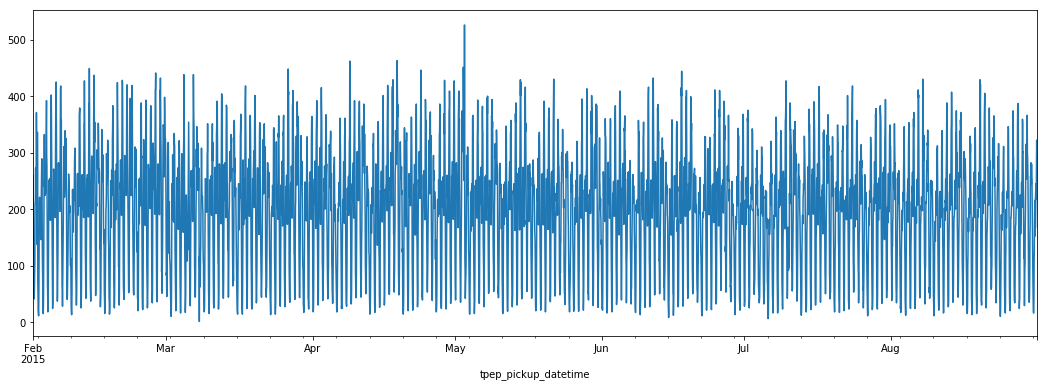

In [4]:
plt.rcParams["figure.figsize"] = (18,6)
data['count'].plot()
#data['count'][24*11:24*12].plot()
#data.tpep_pickup_datetime[26:27][0].hour
#data.tpep_pickup_datetime.map(lambda x: x.weekday())

Составим признаки для регресии

In [26]:
#Зададим порядковый номер записи
data['rn'] =  range(1, data.shape[0] + 1)

K = 2
for k in range(1, K + 1):
    data.loc[:,'s'+ str(k)] = np.sin(data['rn'] * 2 * np.pi * k / 168)
    data.loc[:,'c'+ str(k)] = np.cos(data['rn'] * 2 * np.pi * k / 168)
    
def getDayPart(date_time):
    #return date_time.hour
   
    if date_time.weekday() == 6:
        if 4 <= date_time.hour and date_time.hour <= 9:
            return 0;
        if 10 <= date_time.hour and date_time.hour <= 19:
            return 1;
        if 20 <= date_time.hour or date_time.hour <= 5:
            return 0;
    else:
        if 1 <= date_time.hour and date_time.hour <= 6:
            return 0;
        if 7 <= date_time.hour and date_time.hour <= 18:
            return 1;
        if 19 <= date_time.hour and date_time.hour <= 22:
            return 2;
        if 23 <= date_time.hour or date_time.hour == 0:
            return 0;

def getDayPartW(date_time):
    val = getDayPart(date_time)
    return val
        
data.loc[:, 'day_part'] = data.tpep_pickup_datetime.map(getDayPart)

#data.head(30)

Сделем регрессию ряда на сгенерированные выше признаки и посмотрим на остатки регресии:

47.1942957946


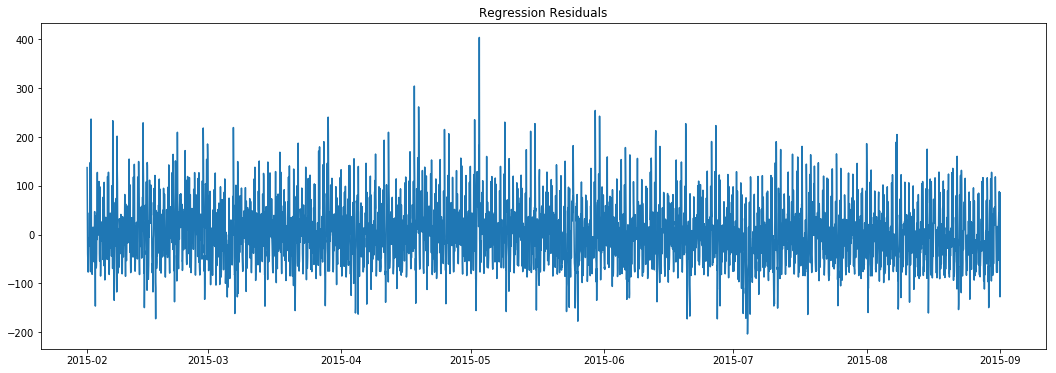

In [27]:
x_names = []
for k in range(1, K + 1):
    x_names.append('s'+ str(k))
    x_names.append('c'+ str(k))

x_names.append('day_part')
    
m1 = smf.ols('count ~ ' + str.join(' + ', x_names), 
             data=data)
fitted = m1.fit()
plt.rcParams["figure.figsize"] = (18,6)
plt.title('Regression Residuals')
plt.plot(fitted.resid)

predictions = fitted.predict(data[x_names])
print metrics.mean_absolute_error(data['count'], predictions)

Проверим среднее и критерий Дики-Фуллера для остатков и визуально изучим STL декомпозицию:

5.60055146913e-14
3.37466533405e-14


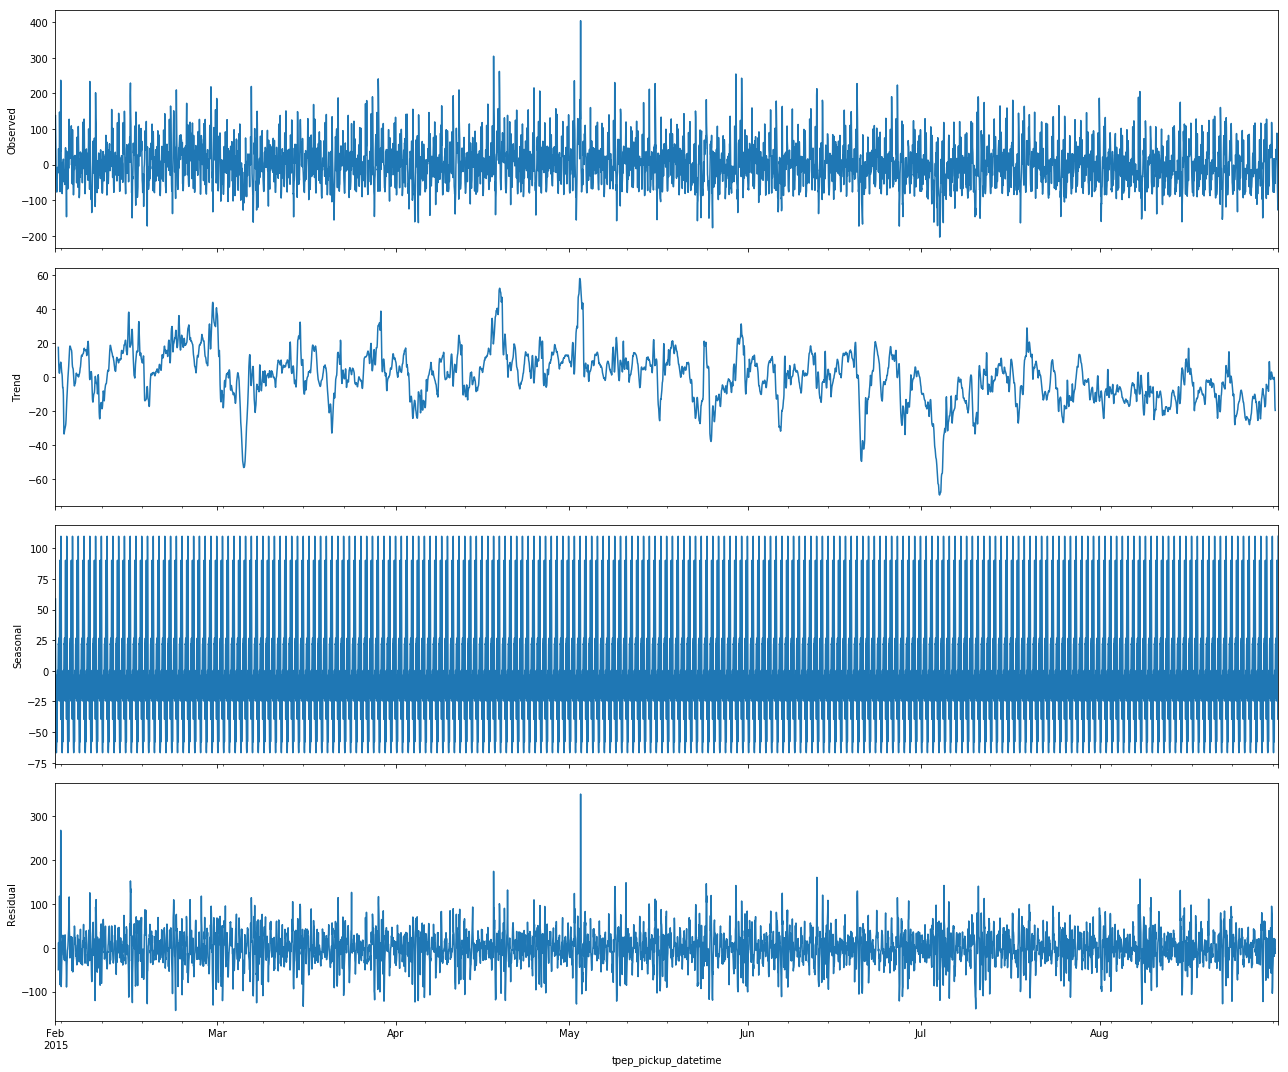

In [28]:
print fitted.resid.mean()
print sm.tsa.stattools.adfuller(fitted.resid)[1]

plt.rcParams["figure.figsize"] = (18,15)
dec = sm.tsa.seasonal_decompose(fitted.resid)
dec.plot()
pylab.show()
#print dec.seasonal[:31].plot()
plt.show()

Критерий Дики-Фуллера отвергает гипотезу о нестационарности, однако визуально видно уменьшение тренда. Проведем внутрисуточное дифференцирование (12 часов) т.к. всплески количества поездок случаются дважды в сутки (утро и вечер):

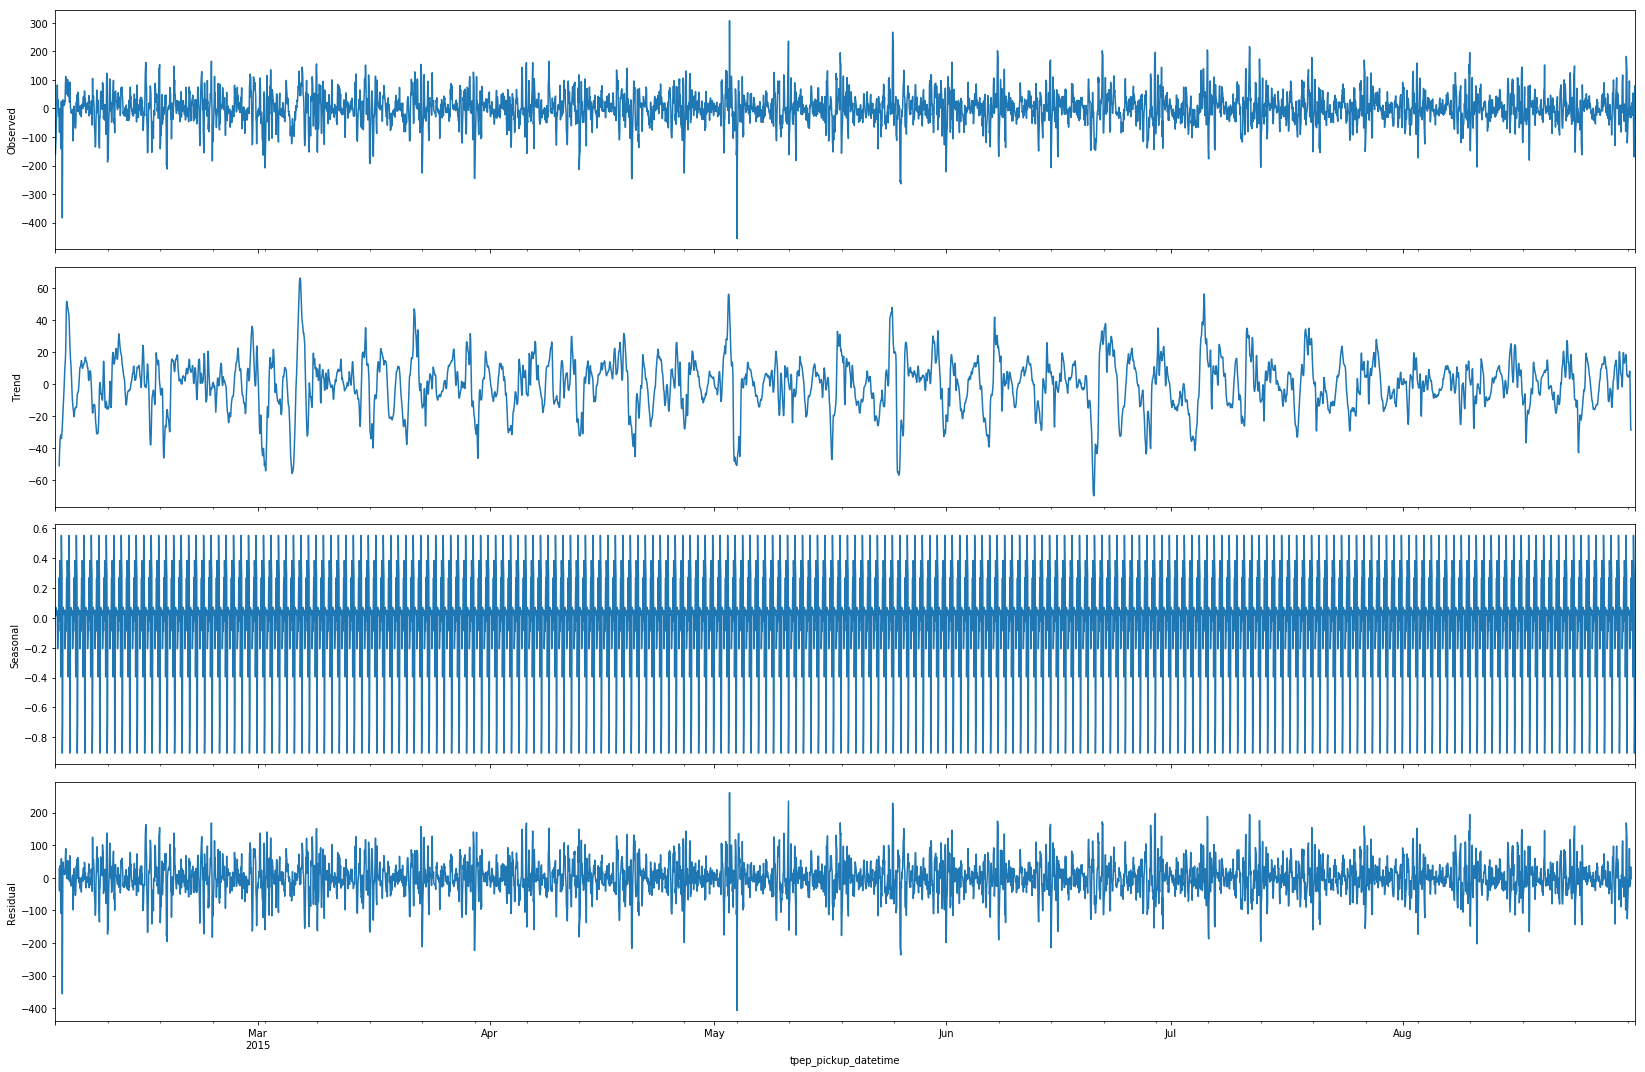

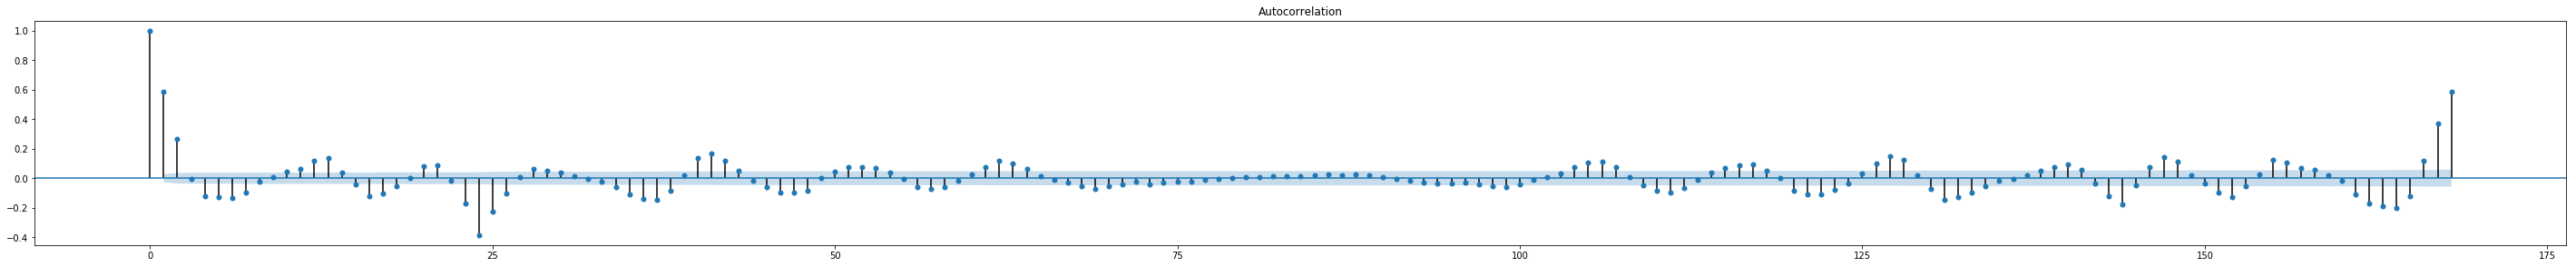

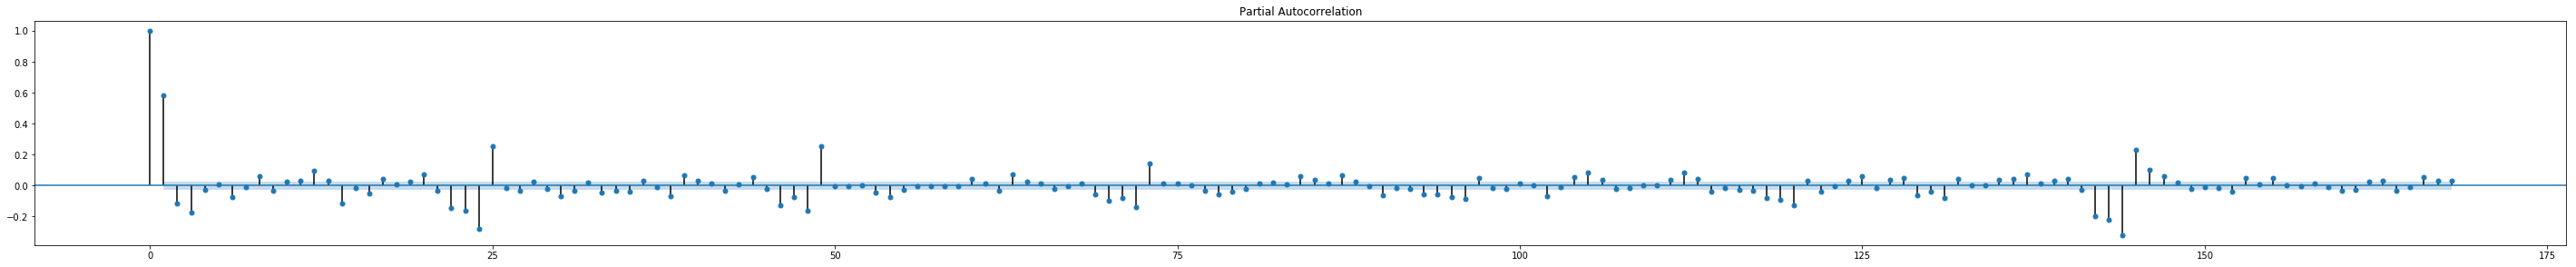

In [29]:
lag = 24
data['resid_diff_24'] = fitted.resid - fitted.resid.shift(lag)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24'][lag:])

plt.rcParams["figure.figsize"] = (23,15)
dec.plot()
#dec.trend.plot()
pylab.show()

plt.figure(figsize(50,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['resid_diff_24'][(lag):].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['resid_diff_24'][(lag):].values.squeeze(), lags=168, ax=ax)
pylab.show()

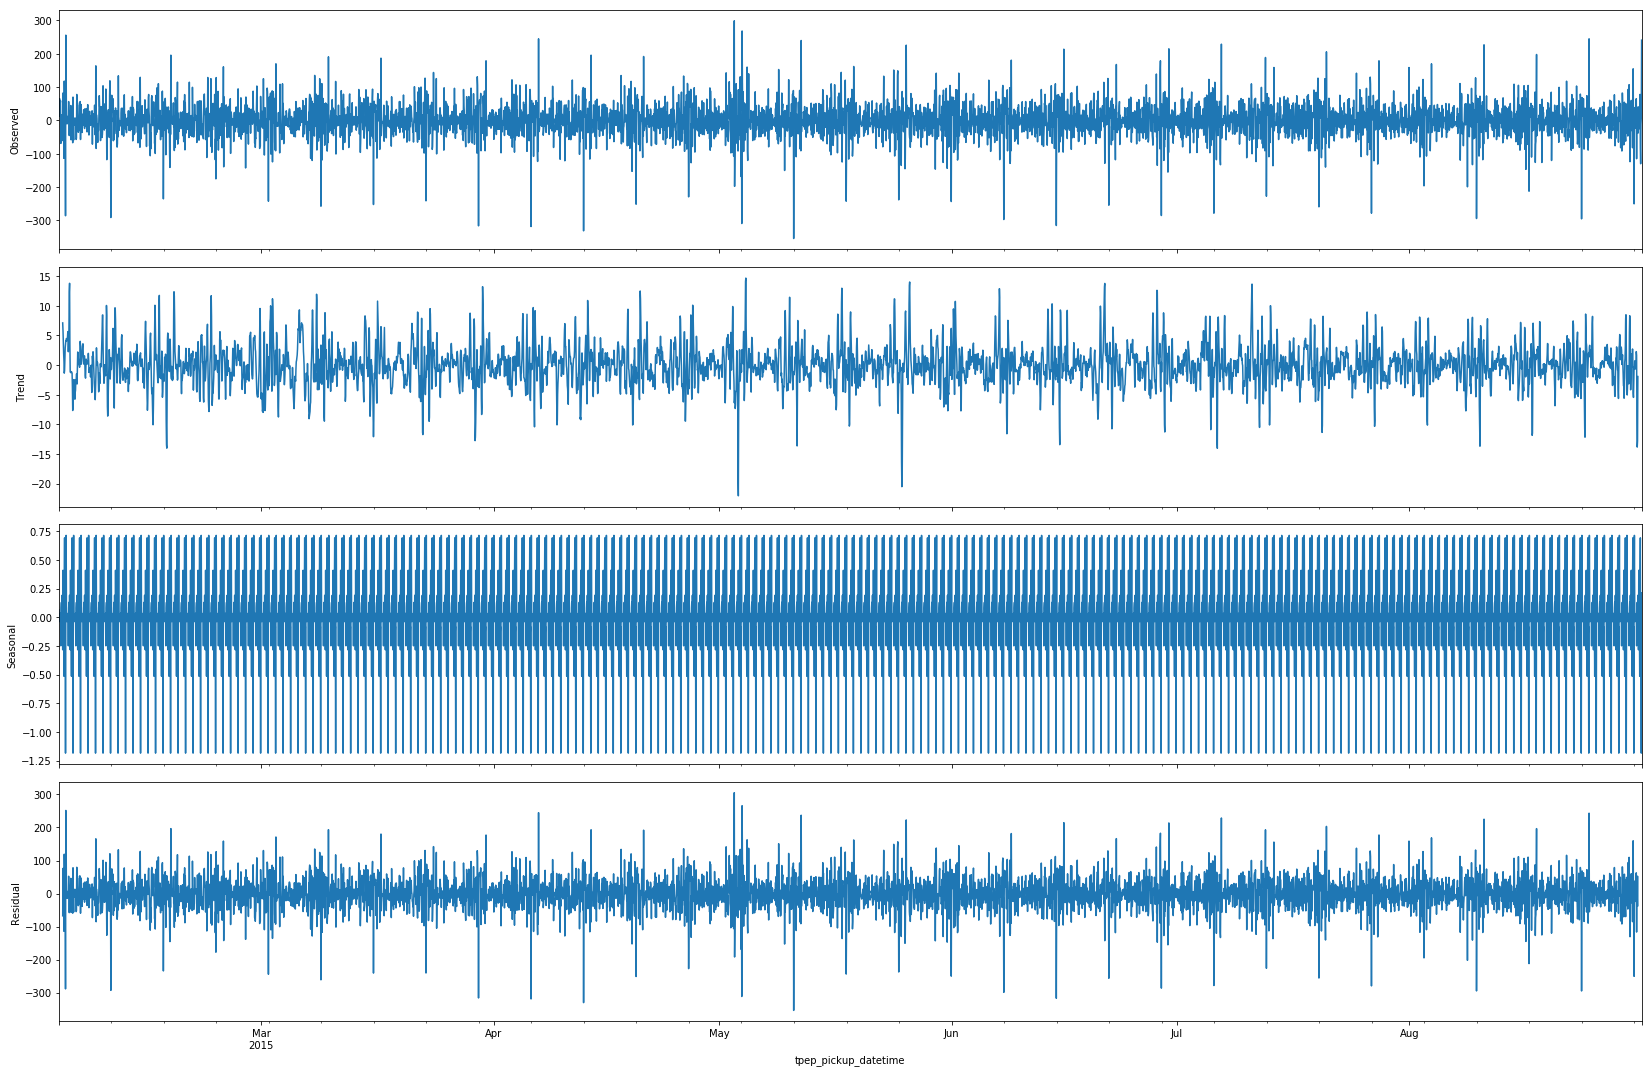

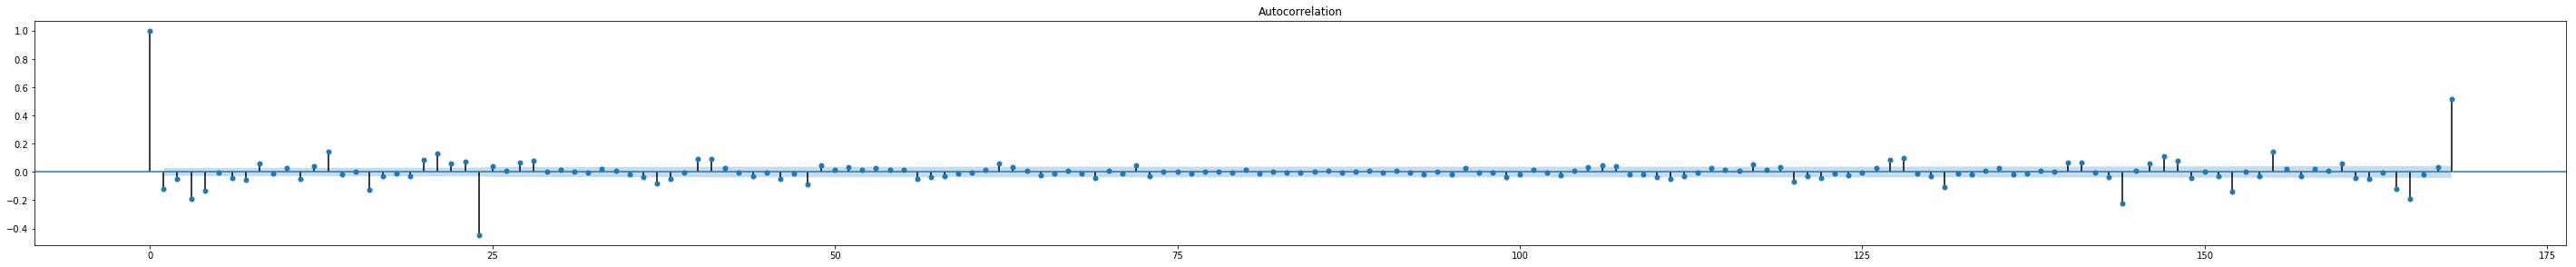

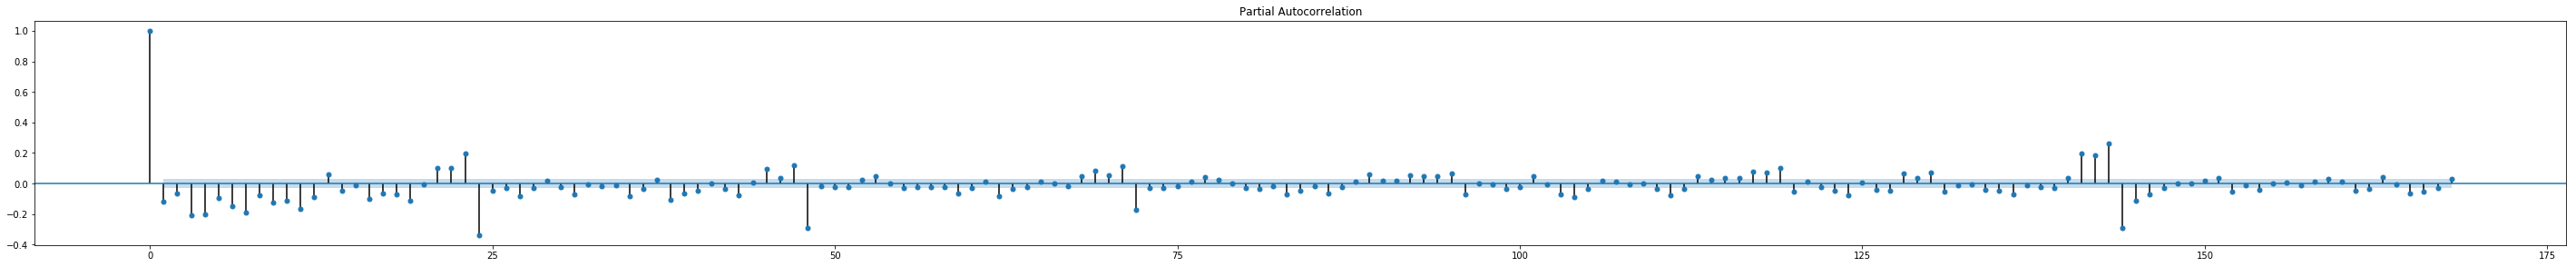

In [30]:
lag2 = 1
data['resid_diff_24_1'] = data['resid_diff_24'] - data['resid_diff_24'].shift(lag2)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24_1'][(lag + lag2):])
plt.rcParams["figure.figsize"] = (23,15)
dec.plot()
#dec.trend.plot()
pylab.show()

plt.figure(figsize(50,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['resid_diff_24_1'][(lag + lag2):].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['resid_diff_24_1'][(lag + lag2):].values.squeeze(), lags=168, ax=ax)
pylab.show()

Теперь ряд больше похож на стационарный. Посмотрим на ACF и PACF полученного ряда:

Подберем начальные приближения для параметров модели исходя из ACF и PACF:

In [33]:
Q = 1 
q = 2 
P = 2
p = 2

#Для полного перебора можно раскомментировать строки кода ниже
ps = [1] #range(0, p + 1)
d = 1 #Ноль обычных дифференцирований
qs = [1]# range(0, q + 1)
Ps = [3]#range(0, P + 1)
D = 1 #Одно сезонное дифференцирование
Qs = [ 1]#range(0, Q + 1)

In [34]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print len(parameters_list)

1


Подберем модель. Будем использовать признаки регресии как параметр exog:

In [ ]:
#%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
ind = 0
for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        print ind, param
        ind += 1
        model=sm.tsa.statespace.SARIMAX(data['count'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], lag), exog=data[x_names]).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

0 (1, 1, 3, 1)


In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
0  (1, 1, 2, 1)  6413.200225


Изучим модель с наименьшим AIC:

Критерий Стьюдента: p=0.329923
Критерий Дики-Фуллера: p=0.000000


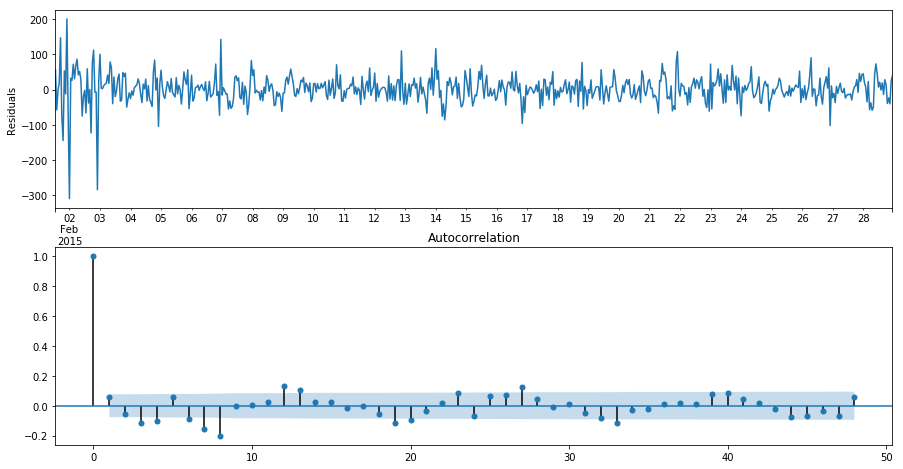

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % sc.stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально). Однако присутствует некоторая автокореллированность связанная возможно с неполнотой инфорации (признаков) о сезонности.
Посмотрим, насколько хорошо модель описывает данные:

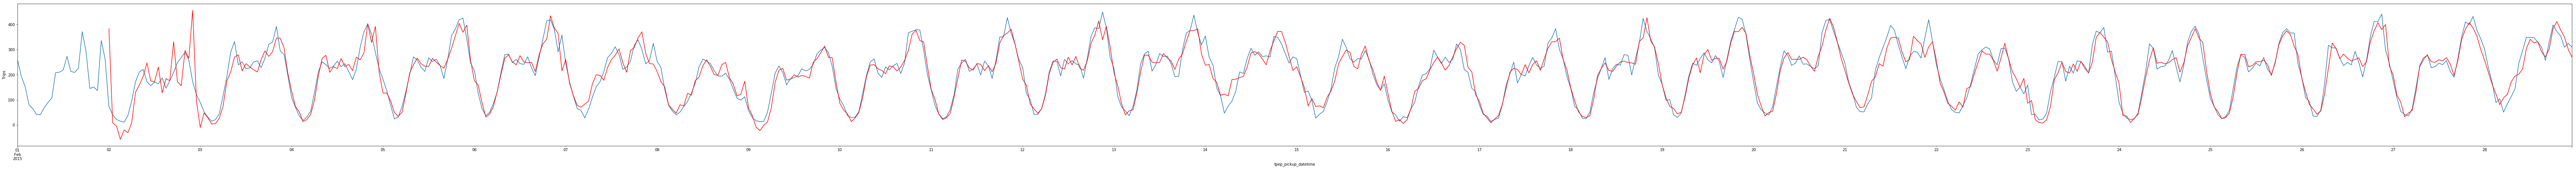

In [17]:
data['model'] = best_model.fittedvalues
plt.figure(figsize(123,7))
data['count'].plot()
data['model'][lag:].plot(color='r')
plt.ylabel('Trips')
pylab.show()

Можно сделать вывод о том что модель неплохо описывает данные, однако можно поработать над улучшение прогнозов внутрисуточной сезонности.
Видно, что модель не очень хорошо прогнозирует значения ряда близкие к средним, они находятся внутри недель(разница между будними и выходными, начало и конец недели).
Как вариант - сгенерировать признаки с для учета внутринедельной сезонности.
Кроме того можно более подробно рассмотреть признаки внутри суток и учесть не только два максимума в течение суток. 
